__Remember__: 
 * Everything takes longer than expected
 * Break into separate notebooks when analysis gets long enough

# Setup

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import scipy.stats

In [98]:
raw_reporter = pd.read_csv('data/reporter20180720.csv', 
                     parse_dates=['Timestamp of Report (Local Time)']
                    ).rename(columns={'Timestamp of Report (Local Time)':'ts', 'Choose intervention ':'intervention', 'How does your stomach feel?':'outcome'}
                    ).set_index('ts')
raw_reporter['outcome'] = raw_reporter['outcome'].apply(lambda x: x.strip() if pd.notnull(x) else '')
raw_reporter['day'] = pd.to_datetime(raw_reporter.index.date)
reporter = raw_reporter[['day', 'intervention', 'outcome']].copy()
reporter.tail()

day intervention       outcome
ts                                                       
2018-07-19 22:03:17 2018-07-19          NaN  Totally fine
2018-07-19 22:03:39 2018-07-19          NaN              
2018-07-20 06:26:49 2018-07-20          NaN              
2018-07-20 06:26:54 2018-07-20          Nex   Distracting
2018-07-20 07:35:46 2018-07-20     GinGin2x    Noticeable

In [112]:
# Missing values are probably sleep/wake, 
#though look deeper if there are too many
reporter.outcome.value_counts()

Noticeable      88
                34
Totally fine    32
Distracting     16
Name: outcome, dtype: int64

In [89]:
reporter.intervention.value_counts()

Tummy Drop (1ct)                       14
Ginger tea                             11
Nex                                     9
GinGin2x                                9
Tummy Drop (2ct)                        3
Milk 1c                                 3
Motion sickness medication              3
Exercise                                3
Tums1x                                  3
Nex,Tums1x                              1
Nex,GinGin2x                            1
Exercise,Motion sickness medication     1
Tums2x                                  1
Name: intervention, dtype: int64

In [82]:
raw_mfp = pd.read_csv('data/Nutrition-Summary-2017-04-25-to-2018-07-20.csv')
raw_mfp.columns = raw_mfp.columns.str.lower().str.replace(' \(g\)', '').str.replace(' \(mg\)', '').str.replace(' ', '_')
raw_mfp['ts'] = raw_mfp.apply(lambda x: str(x['date']), axis=1) # + ' ' + str(x['time']), axis=1)
raw_mfp['ts'] = pd.to_datetime(raw_mfp['ts'], errors='coerce')
mfp = raw_mfp.set_index(['ts']).loc['2018-07-01':, ['calories', 'fat', 'saturated_fat']]
mfp.tail()

calories   fat  saturated_fat
ts                                       
2018-07-19     431.7  12.0            0.0
2018-07-19     928.8  32.3            7.1
2018-07-19     121.5   6.7            0.7
2018-07-19      80.0   2.0            0.0
2018-07-20    1451.8  22.0            7.1

In [168]:
raw_mfp.head().T

0                    1  \
date                          2017-04-25           2017-04-26   
meal                              Dinner            Breakfast   
time                                 NaN                  NaN   
calories                           334.5                  110   
fat                                 15.4                    0   
saturated_fat                        4.8                    0   
polyunsaturated_fat                    3                    0   
monounsaturated_fat                  5.4                    0   
trans_fat                              0                    0   
cholesterol                          558                    0   
sodium                               413                    0   
potassium                            207                    0   
carbohydrates                       26.2                    3   
fiber                                  1                    0   
sugar                                1.6                    2   
protein                             22.9                    0   
vitamin_a                           16.2                    0   
vitamin_c                              0                    0   
calcium                             16.4                    0   
iron                                22.7                    0   
note                      N:Distracting                   NaN   
ts                   2017-04-25 00:00:00  2017-04-26 00:00:00   

                                       2                    3  \
date                          2017-04-26           2017-04-26   
meal                               Lunch               Dinner   
time                                 NaN                  NaN   
calories                           381.5                  617   
fat                                  7.3                 25.4   
saturated_fat                          0                 10.6   
polyunsaturated_fat                  0.1                  0.5   
monounsaturated_fat                    0                  2.5   
trans_fat                              0                    0   
cholesterol                           25                  103   
sodium                            1073.1                  906   
potassium                          470.9                  330   
carbohydrates                       58.1                 56.3   
fiber                                6.8                    4   
sugar                               12.9                   15   
protein                             21.4                 33.4   
vitamin_a                             17                   35   
vitamin_c                           43.4                    6   
calcium                              5.4                    4   
iron                                20.5                   21   
note                                 NaN                  NaN   
ts                   2017-04-26 00:00:00  2017-04-26 00:00:00   

                                       4  
date                          2017-04-26  
meal                              Snacks  
time                                 NaN  
calories                            89.8  
fat                                  0.3  
saturated_fat                        0.1  
polyunsaturated_fat                  0.1  
monounsaturated_fat                    0  
trans_fat                              0  
cholesterol                            0  
sodium                                 1  
potassium                          361.2  
carbohydrates                         23  
fiber                                2.6  
sugar                               12.3  
protein                              1.1  
vitamin_a                            1.3  
vitamin_c                           14.6  
calcium                              0.5  
iron                                 1.5  
note                                 NaN  
ts                   2017-04-26 00:00:00

In [83]:
assert not any(mfp.index.isna())

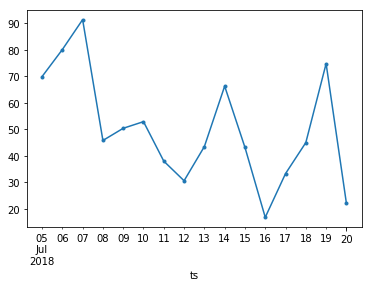

In [85]:
mfp.groupby(pd.Grouper(level=0, freq='1d')).fat.sum().plot(marker='.')

In [109]:
print(reporter.index.size)
print(mfp.index.size)
df = reporter.merge(mfp.groupby(level=0).sum(), 
                    left_on='day', 
                    right_index=True).sort_index()
print(df.index.size)
df.tail()

170
65
159


day intervention       outcome  calories   fat  \
ts                                                                          
2018-07-19 22:03:17 2018-07-19          NaN  Totally fine    2851.0  74.7   
2018-07-19 22:03:39 2018-07-19          NaN                  2851.0  74.7   
2018-07-20 06:26:49 2018-07-20          NaN                  1451.8  22.0   
2018-07-20 06:26:54 2018-07-20          Nex   Distracting    1451.8  22.0   
2018-07-20 07:35:46 2018-07-20     GinGin2x    Noticeable    1451.8  22.0   

                     saturated_fat  
ts                                  
2018-07-19 22:03:17           14.8  
2018-07-19 22:03:39           14.8  
2018-07-20 06:26:49            7.1  
2018-07-20 06:26:54            7.1  
2018-07-20 07:35:46            7.1

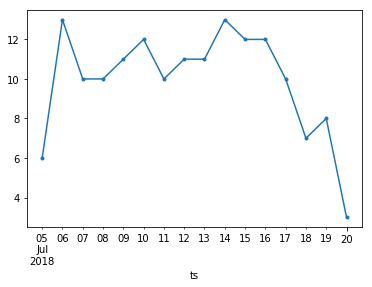

In [110]:
df.groupby(pd.Grouper(level=0, freq='1d')).size().plot(marker='.')

# Data Exploration

In [111]:
df.tail(30)

day                intervention       outcome  \
ts                                                                         
2018-07-16 19:48:19 2018-07-16                      Tums1x    Noticeable   
2018-07-16 22:30:08 2018-07-16                         NaN                 
2018-07-17 06:36:40 2018-07-17                         NaN                 
2018-07-17 06:36:46 2018-07-17                Nex,GinGin2x    Noticeable   
2018-07-17 07:22:55 2018-07-17                         NaN    Noticeable   
2018-07-17 10:19:10 2018-07-17                    GinGin2x    Noticeable   
2018-07-17 11:37:33 2018-07-17                         NaN  Totally fine   
2018-07-17 12:37:15 2018-07-17                      Tums1x   Distracting   
2018-07-17 16:24:57 2018-07-17                         NaN    Noticeable   
2018-07-17 18:13:18 2018-07-17                         NaN    Noticeable   
2018-07-17 21:14:15 2018-07-17                         NaN  Totally fine   
2018-07-17 21:31:56 2018-07-17                         NaN                 
2018-07-18 06:13:04 2018-07-18                         NaN                 
2018-07-18 06:18:11 2018-07-18                         Nex    Noticeable   
2018-07-18 07:16:18 2018-07-18                    GinGin2x    Noticeable   
2018-07-18 11:34:29 2018-07-18                         NaN  Totally fine   
2018-07-18 13:22:41 2018-07-18                         NaN    Noticeable   
2018-07-18 16:57:09 2018-07-18            Tummy Drop (2ct)    Noticeable   
2018-07-18 22:26:09 2018-07-18                         NaN                 
2018-07-19 07:09:26 2018-07-19                         NaN                 
2018-07-19 07:25:29 2018-07-19                         Nex    Noticeable   
2018-07-19 12:24:57 2018-07-19  Motion sickness medication    Noticeable   
2018-07-19 13:29:06 2018-07-19            Tummy Drop (2ct)    Noticeable   
2018-07-19 16:25:12 2018-07-19                         NaN    Noticeable   
2018-07-19 21:12:16 2018-07-19                  Ginger tea  Totally fine   
2018-07-19 22:03:17 2018-07-19                         NaN  Totally fine   
2018-07-19 22:03:39 2018-07-19                         NaN                 
2018-07-20 06:26:49 2018-07-20                         NaN                 
2018-07-20 06:26:54 2018-07-20                         Nex   Distracting   
2018-07-20 07:35:46 2018-07-20                    GinGin2x    Noticeable   

                     calories   fat  saturated_fat  
ts                                                  
2018-07-16 19:48:19     801.5  16.7            4.1  
2018-07-16 22:30:08     801.5  16.7            4.1  
2018-07-17 06:36:40    1492.0  33.2            5.0  
2018-07-17 06:36:46    1492.0  33.2            5.0  
2018-07-17 07:22:55    1492.0  33.2            5.0  
2018-07-17 10:19:10    1492.0  33.2            5.0  
2018-07-17 11:37:33    1492.0  33.2            5.0  
2018-07-17 12:37:15    1492.0  33.2            5.0  
2018-07-17 16:24:57    1492.0  33.2            5.0  
2018-07-17 18:13:18    1492.0  33.2            5.0  
2018-07-17 21:14:15    1492.0  33.2            5.0  
2018-07-17 21:31:56    1492.0  33.2            5.0  
2018-07-18 06:13:04    2396.0  44.9            8.0  
2018-07-18 06:18:11    2396.0  44.9            8.0  
2018-07-18 07:16:18    2396.0  44.9            8.0  
2018-07-18 11:34:29    2396.0  44.9            8.0  
2018-07-18 13:22:41    2396.0  44.9            8.0  
2018-07-18 16:57:09    2396.0  44.9            8.0  
2018-07-18 22:26:09    2396.0  44.9            8.0  
2018-07-19 07:09:26    2851.0  74.7           14.8  
2018-07-19 07:25:29    2851.0  74.7           14.8  
2018-07-19 12:24:57    2851.0  74.7           14.8  
2018-07-19 13:29:06    2851.0  74.7           14.8  
2018-07-19 16:25:12    2851.0  74.7           14.8  
2018-07-19 21:12:16    2851.0  74.7           14.8  
2018-07-19 22:03:17    2851.0  74.7           14.8  
2018-07-19 22:03:39    2851.0  74.7           14.8  
2018-07-20 06:26:49    1451.8  22.0            7.1  
2018

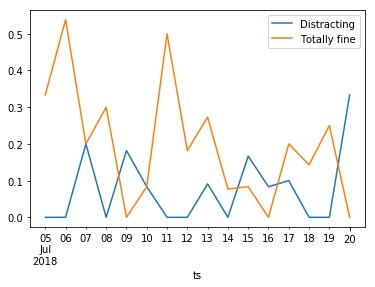

In [120]:
temp = pd.get_dummies(df['outcome'])
temp.loc[:, ['Distracting', 'Totally fine']].groupby(pd.Grouper(freq='1d')).mean().plot()

# Analysis Template

In [141]:
def prepost_generator(intervention, window=2):
    """Return df formatted for easy pre/post analysis"""
    outcome_list = [x for x in reporter.outcome.unique().tolist() if len(x)]
    prepost_intervention = pd.DataFrame(columns=pd.MultiIndex.from_product([['pre', 'post'], outcome_list]))
    for ix in reporter[reporter.intervention == intervention].index:
        for arm, outcome in prepost_intervention.columns:
            if arm == 'pre':
                prepost_intervention.loc[ix, (arm, outcome)] = reporter[  (1==1)
                                                  & (reporter.index > ix - pd.Timedelta(window, 'h'))
                                                  & (reporter.index <= ix)
                                                  & (reporter.outcome == outcome)
                                                 ].index.size
            elif arm == 'post':
                prepost_intervention.loc[ix, (arm, outcome)] = reporter[  (1==1)
                                                  & (reporter.index > ix)
                                                  & (reporter.index <= ix + pd.Timedelta(window, 'h'))
                                                  & (reporter.outcome == outcome)
                                                 ].index.size
            else:
                raise ValueError('arm should only be pre or post')

    return prepost_intervention

prepost_intervention = prepost_generator('Tummy Drop (1ct)', window=2)
prepost_intervention.tail()

pre                                post  \
                    Distracting Noticeable Totally fine Distracting   
2018-07-10 13:03:03         1.0        1.0          0.0         0.0   
2018-07-10 14:51:42         0.0        2.0          0.0         0.0   
2018-07-11 10:24:23         0.0        2.0          0.0         0.0   
2018-07-11 12:42:05         0.0        1.0          0.0         0.0   
2018-07-13 13:18:36         0.0        3.0          0.0         0.0   

                                             
                    Noticeable Totally fine  
2018-07-10 13:03:03        1.0          0.0  
2018-07-10 14:51:42        0.0          0.0  
2018-07-11 10:24:23        0.0          0.0  
2018-07-11 12:42:05        0.0          1.0  
2018-07-13 13:18:36        0.0          0.0

In [142]:
def generate_confusion_matrix(prepost_intervention, target):
    confusion_matrix = prepost_intervention.sum(axis=0).unstack().loc[:, ['Noticeable', target]]
    oddsratio, pvalue = scipy.stats.fisher_exact(confusion_matrix.values)
    print('p-value of no effect: {:0.2f}'.format(pvalue))
    
    confusion_matrix['ratio'] = confusion_matrix.iloc[:, 1].div(confusion_matrix.sum(axis=1))
    return confusion_matrix

confusion_matrix = generate_confusion_matrix(prepost_intervention, 'Totally fine')
confusion_matrix

p-value of no effect: 0.20


Noticeable  Totally fine     ratio
post         6.0           2.0  0.250000
pre         18.0           1.0  0.052632

In [143]:
# This isn't quite fair, since I take nexium at the exact same time each day,
# it is probably mostly a measure of my feeling worse in the mornings
prepost_intervention = prepost_generator('Nex', window=10)
confusion_matrix = generate_confusion_matrix(prepost_intervention, 'Totally fine')
confusion_matrix

p-value of no effect: 0.03


Noticeable  Totally fine     ratio
post        32.0           4.0  0.111111
pre         11.0           7.0  0.388889

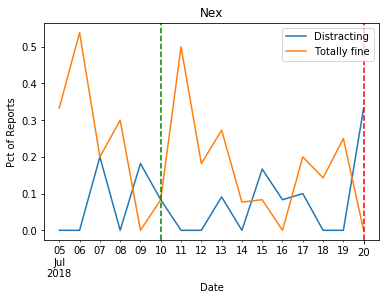

In [163]:
intervention = 'Nex'
def plot_prepost(intervention):
    min_day = df[df.intervention == intervention].index.min()
    max_day = df[df.intervention == intervention].index.max()
    ax = pd.get_dummies(df['outcome'])[['Distracting', 'Totally fine']].groupby(pd.Grouper(freq='1d')).mean().plot()
    ax.axvline(min_day, c='g', linestyle='--')
    ax.axvline(max_day, c='r', linestyle='--')
    ax.set_xlabel('Date')
    ax.set_ylabel('Pct of Reports')
    ax.set_title(intervention)
    ax.get_figure().savefig('results/{}_{:%Y%m%d}.png'.format(intervention.replace(' ', '_'), pd.datetime.today()))
    return ax

_ = plot_prepost('Nex')

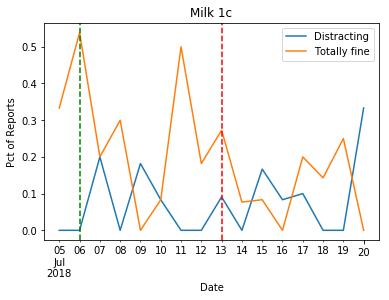

In [165]:
_ = plot_prepost('Milk 1c')

In [144]:
# TODO Bayesian comparison of credible intervals for proportion of each in the pre and post
# https://www.safaribooksonline.com/library/view/bayesian-methods-for/9780133902914/ch07.html
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

# PUT RESULTS HERE
distractingcnt_pre = 10
nondistractingcnt_pre = 10
distractingcnt_post = 10
nondistractingcnt_post = 10

posterior_pre = beta(alpha_prior + distractingcnt_pre,
                    beta_prior + nondistractingcnt_pre)

posterior_post = beta(alpha_prior + distractingcnt_post,
                    beta_prior + nondistractingcnt_post)

samples = 20000 # We want this to be large to get a better approximation.
samples_posterior_pre = posterior_pre.rvs(samples)
samples_posterior_post = posterior_post.rvs(samples)

print("Probability that portion 'distracting' in post is less than pre: {:0.2f}".format((samples_posterior_post < samples_posterior_pre).mean()))

Probability that portion 'distracting' in post is less than pre: 0.50
